In [1]:
!pip3 install seaborn
!pip3 install scanpy
!pip3 install pybiomart
!pip3 install leidenalg
!pip3 install scvi-tools


[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
cwd

'/Users/deanlee/GitHub/FigureOneLab/trevino'

In [4]:
meta = pd.read_csv(cwd+'/data/GSE162170_rna_cell_metadata.txt.gz', compression='gzip', sep='\t')
meta.index = meta['Cell.ID']
meta.index.name = None
meta

,Cell.ID,Sample.ID,Age,Tissue.ID,Sample.Type,Assay,Batch,seurat_clusters,RNA.Counts,RNA.Features,...,Cell.Barcode,DF_pANN,DF_classification,DF_pANN_quantile,Spliced.Counts,Spliced.Features,Unspliced.Counts,Unspliced.Features,Ambiguous.Counts,Ambiguous.Features
hft_w20_p3_r1_AAACCCAAGCTGCGAA,hft_w20_p3_r1_AAACCCAAGCTGCGAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c16,1397,677,...,AAACCCAAGCTGCGAA,0.086339,Singlet,0.356997,1063,544,67,54,94,69
hft_w20_p3_r1_AAACCCAAGGTAGTAT,hft_w20_p3_r1_AAACCCAAGGTAGTAT,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c11,14338,4301,...,AAACCCAAGGTAGTAT,0.325683,Singlet,0.821429,10339,3514,5437,2526,1431,669
hft_w20_p3_r1_AAACCCACAACTCCAA,hft_w20_p3_r1_AAACCCACAACTCCAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c17,9260,3481,...,AAACCCACAACTCCAA,0.397814,Doublet,0.984402,6494,2701,6860,2515,1095,669
hft_w20_p3_r1_AAACCCACATAGTCAC,hft_w20_p3_r1_AAACCCACATAGTCAC,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c0,4025,1969,...,AAACCCACATAGTCAC,0.076503,Singlet,0.314723,2655,1475,5875,2058,634,377
hft_w20_p3_r1_AAACCCAGTACAGGTG,hft_w20_p3_r1_AAACCCAGTACAGGTG,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c4,7131,2930,...,AAACCCAGTACAGGTG,0.239344,Singlet,0.746356,5008,2228,6026,2106,909,556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTGTTGCAGCACCCA,hft_w16_p7_r2_TTTGTTGCAGCACCCA,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c6,8532,3497,...,TTTGTTGCAGCACCCA,0.389488,Doublet,0.961542,6226,2730,4194,2059,973,612
hft_w16_p7_r2_TTTGTTGCAGGCTACC,hft_w16_p7_r2_TTTGTTGCAGGCTACC,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,6689,2393,...,TTTGTTGCAGGCTACC,0.210916,Singlet,0.663941,4757,1877,3039,1362,677,396
hft_w16_p7_r2_TTTGTTGGTCGCTTAA,hft_w16_p7_r2_TTTGTTGGTCGCTTAA,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,3865,1799,...,TTTGTTGGTCGCTTAA,0.074798,Singlet,0.306766,2808,1409,1436,832,431,273
hft_w16_p7_r2_TTTGTTGGTCGTACAT,hft_w16_p7_r2_TTTGTTGGTCGTACAT,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,5293,2365,...,TTTGTTGGTCGTACAT,0.208895,Singlet,0.660796,3660,1760,6166,2211,672,416


In [5]:
%%time
counts = pd.read_csv(cwd+'/data/GSE162170_rna_counts.tsv.gz', compression='gzip', sep='\t')
counts = counts.transpose()
counts

CPU times: user 7min 24s, sys: 45.8 s, total: 8min 10s
Wall time: 10min 31s


,ENSG00000243485,ENSG00000237613,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000239906,ENSG00000241599,ENSG00000236601,ENSG00000284733,ENSG00000235146,...,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,ENSG00000198886,ENSG00000198786,ENSG00000198695,ENSG00000198727
hft_w20_p3_r1_AAACCCAAGCTGCGAA,0,0,0,0,0,0,0,0,0,0,...,10,0,17,16,13,0,6,1,0,4
hft_w20_p3_r1_AAACCCAAGGTAGTAT,0,0,0,0,0,0,0,0,0,0,...,67,1,107,149,61,2,76,5,1,46
hft_w20_p3_r1_AAACCCACAACTCCAA,0,0,0,0,0,0,0,0,0,0,...,32,2,91,74,21,3,39,5,0,44
hft_w20_p3_r1_AAACCCACATAGTCAC,0,0,0,0,0,0,0,0,0,0,...,4,0,10,7,7,0,7,3,0,7
hft_w20_p3_r1_AAACCCAGTACAGGTG,0,0,0,0,0,0,0,0,0,0,...,33,0,50,62,28,0,34,11,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTGTTGCAGCACCCA,0,0,0,0,0,0,0,0,0,0,...,17,0,43,29,6,0,15,3,0,19
hft_w16_p7_r2_TTTGTTGCAGGCTACC,0,0,0,0,0,0,0,0,0,0,...,26,0,76,49,20,1,21,5,0,20
hft_w16_p7_r2_TTTGTTGGTCGCTTAA,0,0,0,0,0,0,0,0,0,0,...,14,0,30,22,9,0,12,3,0,17
hft_w16_p7_r2_TTTGTTGGTCGTACAT,0,0,0,0,0,0,0,0,0,0,...,20,0,41,29,7,0,10,0,0,11


In [6]:
%%time
adata = anndata.AnnData(X=counts,
                        obs=meta,
                        var=counts.columns.to_frame())
adata

CPU times: user 8.36 ms, sys: 6.46 ms, total: 14.8 ms
Wall time: 18.3 ms


AnnData object with n_obs × n_vars = 57868 × 33355
    obs: 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features'
    var: 0

In [7]:
%%time
a = sc.queries.biomart_annotations('hsapiens', ['ensembl_gene_id','hgnc_symbol'])
b = dict(zip(a['ensembl_gene_id'], a['hgnc_symbol']))
adata.var['hgnc_symbol'] = adata.var[0].map(b)
adata.var.index = adata.var['hgnc_symbol']
adata.var.index.name = None
adata.var.drop(columns=[0,'hgnc_symbol'], inplace=True)
adata.var

CPU times: user 342 ms, sys: 215 ms, total: 557 ms
Wall time: 14.4 s


""
MIR1302-2HG
FAM138A
OR4F5
NaN
NaN
...
MT-ND4L
MT-ND4
MT-ND5
MT-ND6


In [8]:
adata.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 57868 × 33355
    obs: 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features'>

In [9]:
a = ~adata.var.index.isnull()
adata = adata[:,a].copy()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
adata

AnnData object with n_obs × n_vars = 57868 × 24849
    obs: 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features'

In [11]:
%%time
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=200)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


CPU times: user 31.6 s, sys: 14.5 s, total: 46 s
Wall time: 57 s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
#sc.pp.subsample(adata, n_obs=40000, random_state=0, copy=False)

In [13]:
%%time
#sc.tl.pca(adata, svd_solver='arpack')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.15 µs


In [14]:
%%time
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
#sc.tl.umap(adata)
#sc.tl.leiden(adata)
#sc.pl.umap(adata, color=['leiden', 'NEUROD2', 'AIF1'])

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 1.91 µs


In [15]:
%%time
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
#adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)

CPU times: user 6.31 s, sys: 8.36 s, total: 14.7 s
Wall time: 22.3 s


In [16]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='Sample.ID')
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/138:   0%|                                      | 0/138 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 138/138: 100%|█| 138/138 [2:59:41<00:00, 46.63s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=138` reached.


Epoch 138/138: 100%|█| 138/138 [2:59:41<00:00, 78.13s/it, v_num=1, train_loss_st
CPU times: user 6h 52min 24s, sys: 1h 1min 38s, total: 7h 54min 2s
Wall time: 2h 59min 43s


In [17]:
%%time
random.seed(17)
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

CPU times: user 26.4 s, sys: 13.7 s, total: 40.1 s
Wall time: 5min 26s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


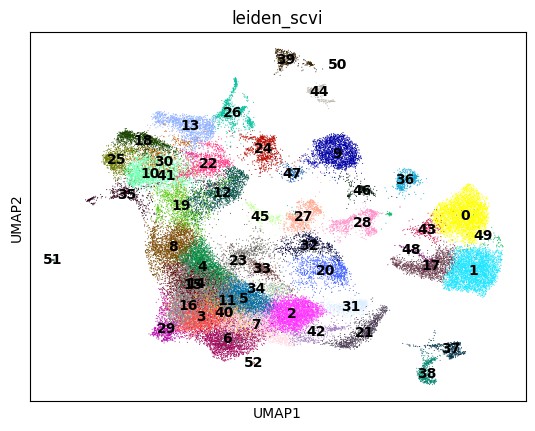

CPU times: user 2min 17s, sys: 1.63 s, total: 2min 18s
Wall time: 11min 28s


In [18]:
%%time
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

In [19]:
%%time
adata.write(cwd+'/outs/231226_trevino_rna_scvi.h5ad')

CPU times: user 305 ms, sys: 7.01 s, total: 7.32 s
Wall time: 25.3 s
